In [1]:
from model import *
from data import *
from keras.models import load_model
from os.path import join as pathjoin
from keras.callbacks import TensorBoard
from keras_unet.models import vanilla_unet
from keras_unet.models import custom_unet
import itertools
from scipy import stats
from skimage import img_as_ubyte, img_as_bool
import numpy as np
from img_utils import *

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

## Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [4]:
grid_length = 256
model_path=f'unet_{grid_length}.hdf5'
# train_dir=r'D:\unet\data\membrane\train'
train_dir=f'{grid_length}/train'
test_dir=f'{grid_length}/test'
steps=3
test_steps=2
log_dir='logs'

In [5]:

# model_checkpoint = ModelCheckpoint(f'unet_{grid_length}.hdf5', monitor='loss',verbose=1, save_best_only=True)

In [6]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(1,train_dir,'image','label',data_gen_args)

In [87]:
samples_gen=flow_samples_from_directories(pathjoin(train_dir,'image'),pathjoin(train_dir,'label'),False)
samples_gen_list=list(samples_gen)
sample_numbers=[0,2,3,4,5,7]*1
# sample_numbers=list(range(len(samples_gen_list)))
steps=len(sample_numbers)
samples_gen=(samples_gen_list[i] for i in sample_numbers)
myGene= itertools.cycle(tuple_map(to_ndarray,star_batchify(samples_gen,1)))

In [7]:
model = unet(lr=0.5e-4)
input_shape=(256,256,1)
# model = vanilla_unet(input_shape=input_shape)
# model = custom_unet(
#     input_shape,
#     use_batch_norm=True,
#     num_classes=1,
#     filters=64,
#     dropout=0.5,
#     output_activation='sigmoid'
# )
# model.compile(
#     optimizer=Adam(lr=1e-4), 
# #     optimizer=SGD(lr=0.01, momentum=0.99),
#     loss='binary_crossentropy',
#     #loss=jaccard_distance,
#     metrics=['accuracy']
# )

D:\dieyepy\src\main\python\model.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


In [89]:
# from keras.optimizers import Adam, SGD
# from keras_unet.metrics import iou, iou_thresholded
# from keras_unet.losses import jaccard_distance
# model.compile(
#     optimizer=Adam(1e-4), 
# #     optimizer=SGD(lr=0.01, momentum=0.99),
#     loss='binary_crossentropy',
#     #loss=jaccard_distance,
#     metrics=['accuracy']
# #     metrics=[iou, iou_thresholded]
# )

In [8]:
model_checkpoint = ModelCheckpoint(model_path, monitor='loss',verbose=1, save_best_only=True)

In [91]:
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [92]:
myGeneCopy,myGene=itertools.tee(myGene,2)

In [ ]:
history = model.fit_generator(myGene,steps_per_epoch=30,epochs=100,callbacks=[model_checkpoint])
# model.fit_generator(myGene,steps_per_epoch=steps,epochs=1,callbacks=[model_checkpoint])

Epoch 1/100
Found 8 images belonging to 1 classes.
Found 8 images belonging to 1 classes.
30/30 [==============================] - 189s 6s/step - loss: 0.6932 - accuracy: 0.5021

Epoch 00001: loss improved from inf to 0.69319, saving model to unet_256.hdf5
Epoch 2/100
30/30 [==============================] - 184s 6s/step - loss: 0.6931 - accuracy: 0.4252

Epoch 00002: loss improved from 0.69319 to 0.69312, saving model to unet_256.hdf5
Epoch 3/100
30/30 [==============================] - 186s 6s/step - loss: 0.9981 - accuracy: 0.4155

Epoch 00003: loss did not improve from 0.69312
Epoch 4/100
30/30 [==============================] - 190s 6s/step - loss: 0.6926 - accuracy: 0.5240

Epoch 00004: loss improved from 0.69312 to 0.69256, saving model to unet_256.hdf5
Epoch 5/100
30/30 [==============================] - 190s 6s/step - loss: 0.6926 - accuracy: 0.5065

Epoch 00005: loss did not improve from 0.69256
Epoch 6/100
30/30 [==============================] - 188s 6s/step - loss: 0.6925 

### test your model and save predicted results

In [ ]:
# best_model=unet(model_path)
best_model=model

In [ ]:
# best_model.save('1_overfit')

In [ ]:
# def testGeneFromTrain():
for i in itertools.islice(myGeneCopy,len(sample_numbers)):
    plt.subplot(141)
    plt.imshow(np.squeeze(i[0]), cmap='gray', vmin=0, vmax=1)
    plt.subplot(142)
    plt.imshow(np.squeeze(i[1]), cmap='gray', vmin=0, vmax=1)
    
    predict_label=best_model.predict(i[0])
    print(predict_label.min(),predict_label.max(),predict_label.mean())
    predict_label=np.squeeze(predict_label)
    
    plt.subplot(143)
    plt.imshow(predict_label, cmap='gray', vmin=0, vmax=1)
    plt.subplot(144)
    predict_label=(predict_label>=0.5).astype(float)
    plt.imshow(predict_label, cmap='gray', vmin=0, vmax=1)
    plt.show()
    
#     yield i[0]
# testGene=testGeneFromTrain()

In [48]:
# testGene =  map(to_ndarray,batchify(flow_test_samples_from_directory(os.path.join(train_dir,'image')),1))
results = model.predict_generator(testGene,steps=1,verbose=1)

(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
1/1 [==============================] - 1s 1s/step


In [49]:
for i,item in enumerate(results):
#     bin_img=(item>=0.5)*255
#     bin_img_u8=bin_img.astype(np.ubyte)
#     print(hist)
    print(item.min(),item.max(),item.mean())

0.76937366 1.0 0.9999909


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1.0 1.0 1.0
1.0 1.0 1.0


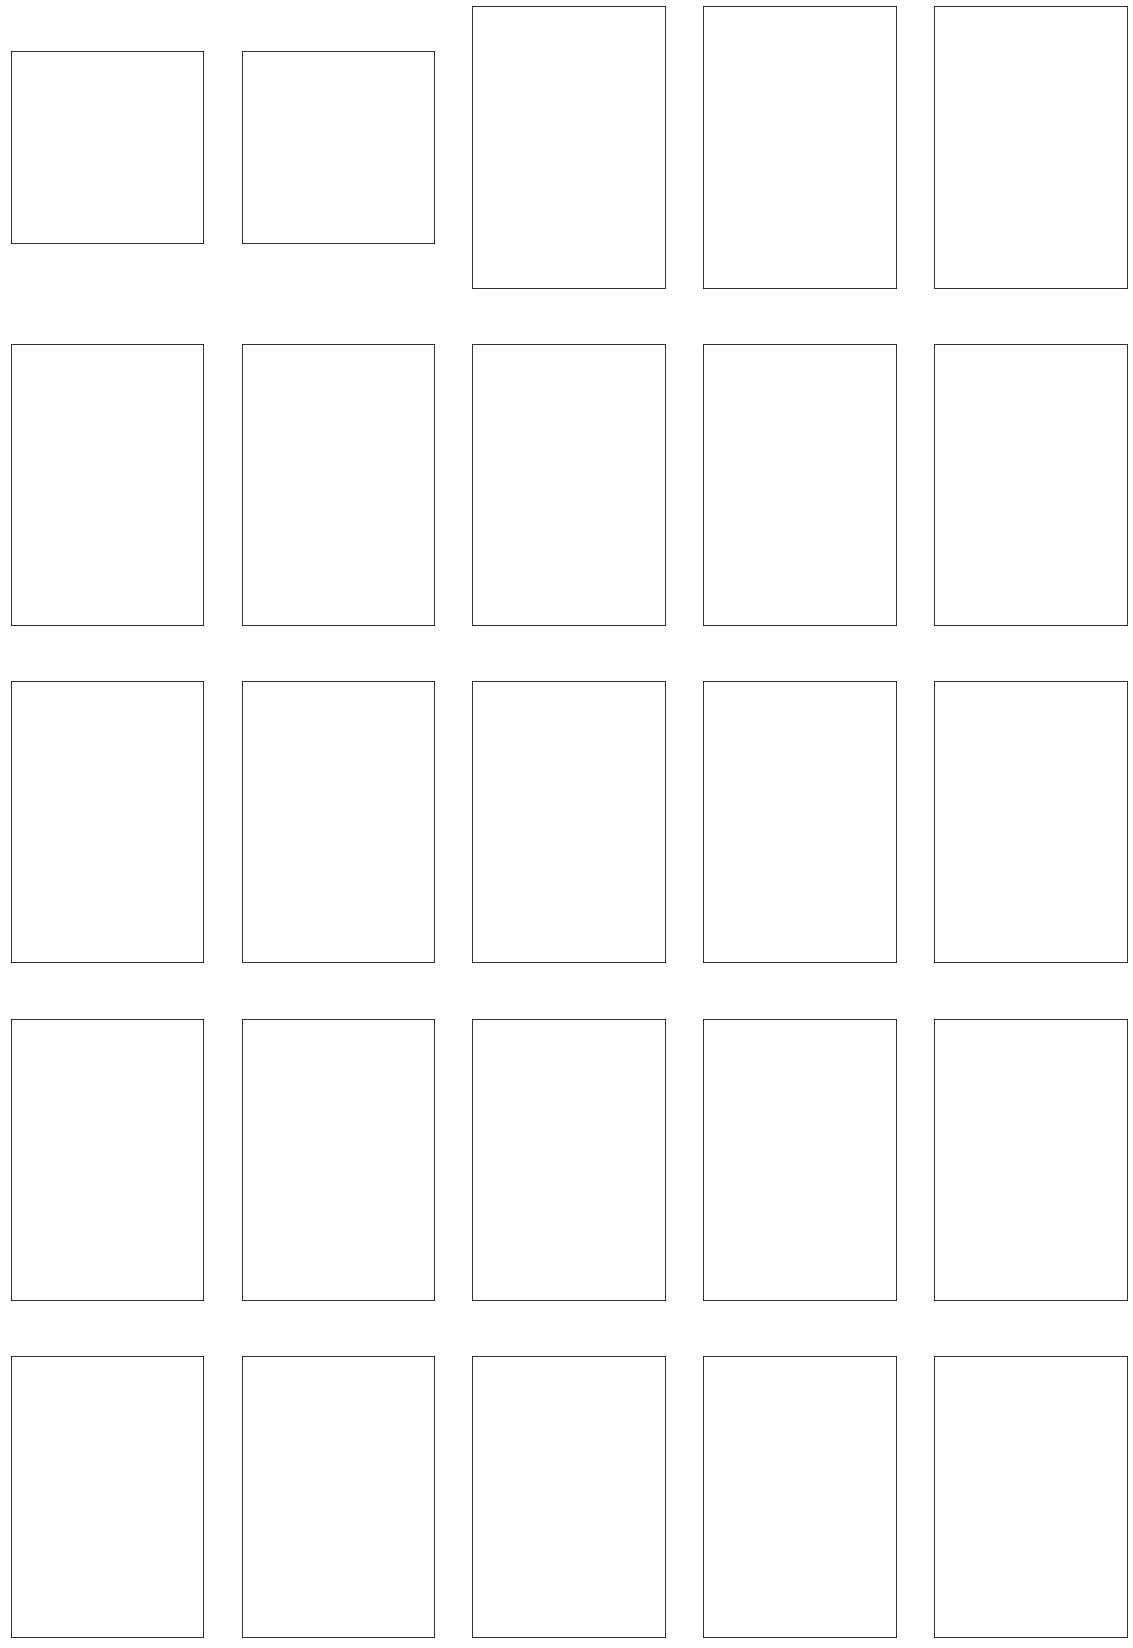

In [30]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20,30), subplot_kw={'xticks': [], 'yticks': []})
for plot_cell, (i, item) in zip(axs.flat,enumerate(results)):
#     img=img>=0.5
#     print(img)
#     img=img_as_ubyte(img)
#     img=img.astype(np.ubyte)
    img=img_as_float(item>=0.5)
    plot_cell.imshow(item[:,:,0], cmap='gray', vmin=0, vmax=1)
    print(img.min(), img.max(), img.mean())
    io.imsave(os.path.join(f'{grid_length}/test/label', f"{i}.png"), item, check_contrast=False)